In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train= pd.read_csv('training.csv')
test= pd.read_csv('test.csv')

# Preprocessing (Training)

In [3]:
train_clean=train.copy()

In [4]:
print("number of duplicates: ",train_clean.duplicated().sum())

number of duplicates:  0


In [5]:
# initial removal of columns I deem unnecesarry

train_clean=train_clean.drop(["patient_id", "education_less_highschool", "education_highschool","education_some_college","education_bachelors",
                              "education_graduate","education_college_or_above","education_stem_degree","married","divorced",
                              "never_married","widowed", "age_median"], axis=1)

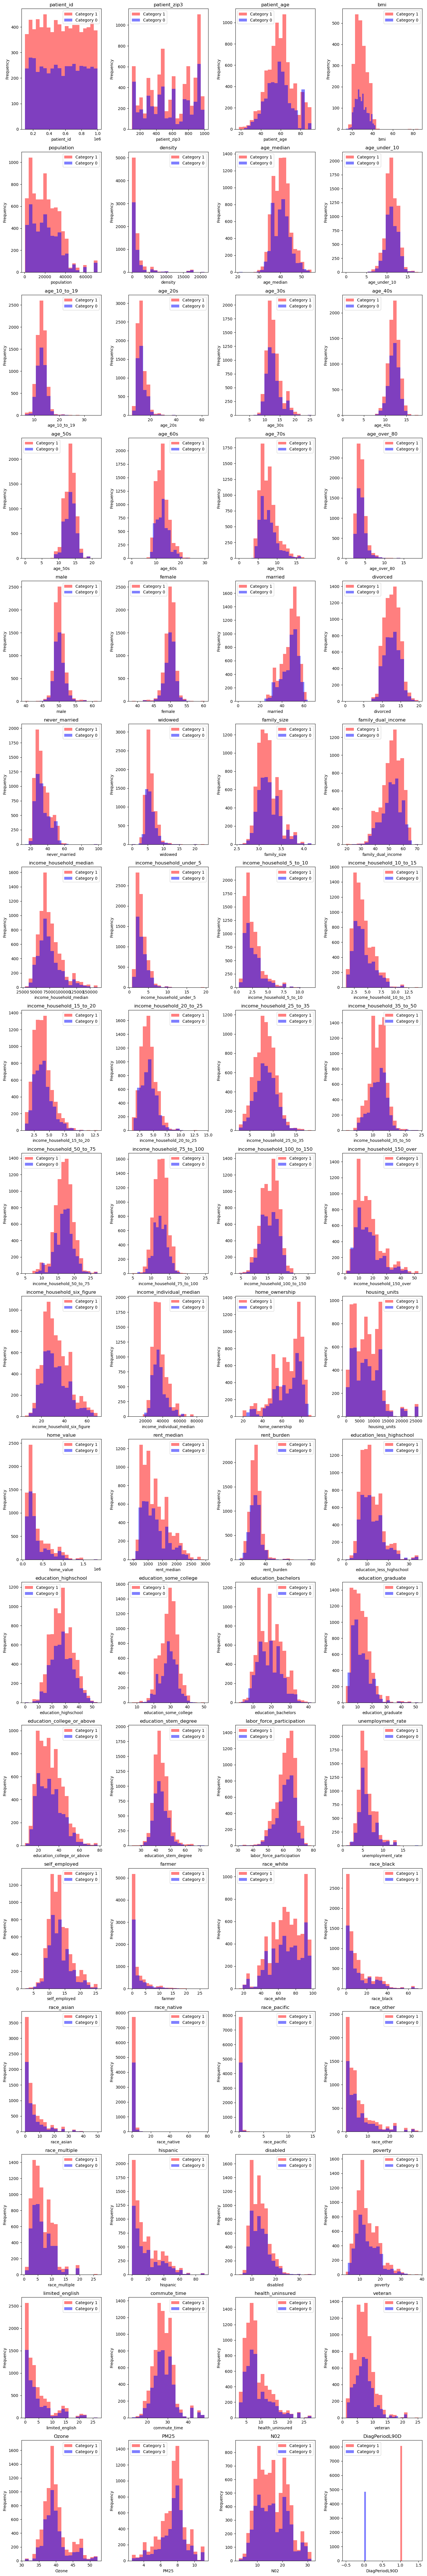

In [6]:
# Look at features
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns

categorical_feature = 'DiagPeriodL90D'
categories = train_clean[categorical_feature].unique()
colors = ['red', 'blue']

n_columns = 4  
n_rows = int(np.ceil(len(numerical_columns) / n_columns))

plt.figure(figsize=(15, 5 * n_rows)) 

for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(n_rows, n_columns, i)  
    for j, category in enumerate(categories):
        category_data = train[train[categorical_feature] == category]
        plt.hist(category_data[col], bins=20, color=colors[j], alpha=0.5, label=f'Category {category}')
    
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(col)
    plt.legend()
    
plt.tight_layout()
plt.show()

In [7]:
from sklearn.utils import resample

# Check the class distribution before and after resampling
print("Original class distribution:")
print(train_clean['DiagPeriodL90D'].value_counts())

# Split the data by class
class_0 = train_clean[train_clean['DiagPeriodL90D'] == 0]
class_1 = train_clean[train_clean['DiagPeriodL90D'] == 1]

# Downsample class 0 to the size of class 1 (to balance)
class_1_downsampled = resample(class_1, 
                               replace=False,  # No replacement
                               n_samples=len(class_0),  # Match the size of class 1
                               random_state=42)

# Combine the downsampled class_0 with class_1
balanced_data = pd.concat([class_1_downsampled, class_0])

# Shuffle the data to randomize order
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the balanced class distribution

print("Balanced class distribution:")
print(balanced_data['DiagPeriodL90D'].value_counts())

Original class distribution:
DiagPeriodL90D
1    8060
0    4846
Name: count, dtype: int64
Balanced class distribution:
DiagPeriodL90D
1    4846
0    4846
Name: count, dtype: int64


In [8]:
balanced_data.shape

(9692, 70)

In [9]:
# adjust the age ranges 


# defining bins and labels for age ranges
age_bins = [0, 19, 39, 59, 69, float('inf')]  # Define bins
age_labels = ['19 and Under', '20-39', '40-59', '60-69', 'Over 70']

train_clean['age_group'] = pd.cut(train_clean['patient_age'], bins=age_bins, labels=age_labels, right=True)
age_dummies = pd.get_dummies(train_clean['age_group'], prefix='age')

balanced_data = pd.concat([train_clean, age_dummies], axis=1)

print(balanced_data[['patient_age'] + list(age_dummies.columns)].head())

   patient_age  age_19 and Under  age_20-39  age_40-59  age_60-69  age_Over 70
0           84             False      False      False      False         True
1           62             False      False      False       True        False
2           43             False      False       True      False        False
3           45             False      False       True      False        False
4           55             False      False       True      False        False


In [10]:
# Replacing missing values in patient_race column with 'prefer not to answer'

balanced_data['patient_race'] = balanced_data['patient_race'].fillna('Prefer Not to Answer')

print(balanced_data['patient_race'].value_counts())

patient_race
Prefer Not to Answer    6385
White                   3588
Black                   1056
Hispanic                 829
Other                    683
Asian                    365
Name: count, dtype: int64


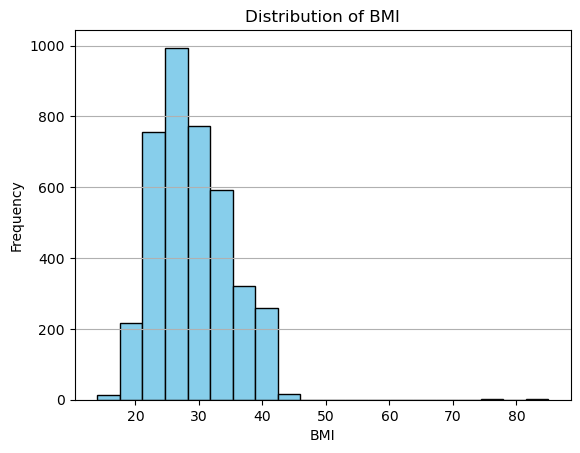

In [11]:
#plot BMI to see what it looks like before editing

plt.hist(balanced_data['bmi'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [12]:
# BMI

# Grouping by age, race, and location to compute the mean BMI for each subgroup
## This will hopefully eliminate biases in the data (fingers crossed)

bmi_means = balanced_data.groupby(['age_group', 'patient_race', 'patient_state'])['bmi'].mean().reset_index()
bmi_means.rename(columns={'bmi': 'mean_bmi'}, inplace=True)

balanced_data = balanced_data.merge(bmi_means, on=['age_group', 'patient_race', 'patient_state'], how='left')

balanced_data['bmi'] = balanced_data['bmi'].fillna(balanced_data['mean_bmi'])


print(balanced_data['bmi'].describe())


count    12458.000000
mean        28.955193
std          3.733892
min         14.000000
25%         27.239167
50%         28.606875
75%         30.431250
max         85.000000
Name: bmi, dtype: float64


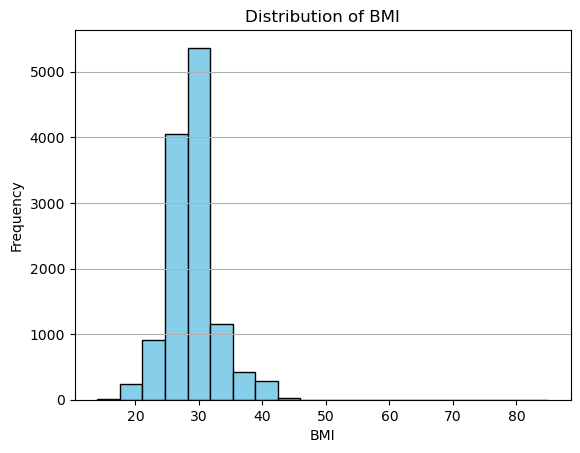

In [13]:
#plot BMI to see what it looks like after editing

plt.hist(balanced_data['bmi'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [14]:
unique_payer_types = balanced_data['payer_type'].unique()
print("Unique values in 'payer_type':", unique_payer_types)


Unique values in 'payer_type': ['MEDICAID' 'COMMERCIAL' 'MEDICARE ADVANTAGE' nan]


In [15]:
# Replacing missing values in payer_type column with 'prefer not to answer'

balanced_data['payer_type'] = balanced_data['payer_type'].fillna('Prefer Not to Answer')

print(balanced_data['payer_type'].value_counts())

payer_type
COMMERCIAL              6032
MEDICAID                2569
MEDICARE ADVANTAGE      2502
Prefer Not to Answer    1803
Name: count, dtype: int64


In [16]:
# One-hot encode the 'payer_type' column
balanced_data = pd.get_dummies(balanced_data, columns=['payer_type'], drop_first=True)


In [17]:
# One-hot encode the 'patient_state' column
balanced_data = pd.get_dummies(balanced_data, columns=['patient_state'], drop_first=True)


In [18]:
# Create a new feature of the locations for the cancers
import re

def categorize_location(description):
    if re.search(r'upper-outer quadrant', description, re.IGNORECASE):
        return 'Upper-Outer Quadrant'
    elif re.search(r'upper-inner quadrant', description, re.IGNORECASE):
        return 'Upper-Inner Quadrant'
    elif re.search(r'lower-outer quadrant', description, re.IGNORECASE):
        return 'Lower-Outer Quadrant'
    elif re.search(r'lower-inner quadrant', description, re.IGNORECASE):
        return 'Lower-Inner Quadrant'
    elif re.search(r'axillary tail', description, re.IGNORECASE):
        return 'Axillary Tail'
    elif re.search(r'nipple and areola', description, re.IGNORECASE):
        return 'Nipple and Areola'
    elif re.search(r'central portion', description, re.IGNORECASE):
        return 'Central Portion'
    elif re.search(r'overlapping sites', description, re.IGNORECASE):
        return 'Overlapping Sites'
    elif re.search(r'unspecified site', description, re.IGNORECASE):
        return 'Unspecified Site'
    elif re.search(r'secondary malignant neoplasm', description, re.IGNORECASE):
        return 'Secondary Malignant Neoplasm'
    elif re.search(r'breast', description, re.IGNORECASE):
        return 'General Breast Cancer'
    else:
        return 'Other'

balanced_data['location_category'] = balanced_data['breast_cancer_diagnosis_desc'].apply(categorize_location)

print(balanced_data[['breast_cancer_diagnosis_desc', 'location_category']].head())

                        breast_cancer_diagnosis_desc      location_category
0  Malignant neoplasm of unsp site of unspecified...  General Breast Cancer
1  Malig neoplm of upper-outer quadrant of right ...   Upper-Outer Quadrant
2  Malignant neoplasm of central portion of left ...        Central Portion
3  Malig neoplasm of upper-inner quadrant of left...   Upper-Inner Quadrant
4  Malignant neoplasm of breast (female), unspeci...  General Breast Cancer


In [19]:
# One-hot encode the 'location_category' column
balanced_data = pd.get_dummies(balanced_data, columns=['location_category'], drop_first=True)


In [20]:
# Drop the unnecesary columns
balanced_data.drop(columns=['mean_bmi','breast_cancer_diagnosis_desc','age_group','age_under_10','age_10_to_19','age_20s','age_30s',
                         'age_30s','age_40s','age_50s','age_60s','age_70s','age_over_80','patient_age','patient_race',
                         'patient_gender','breast_cancer_diagnosis_code','breast_cancer_diagnosis_code',
                          'metastatic_cancer_diagnosis_code','metastatic_first_novel_treatment','metastatic_first_novel_treatment_type',
                         'Region','Division','labor_force_participation','unemployment_rate','self_employed','farmer','payer_type_MEDICAID','payer_type_MEDICARE ADVANTAGE','payer_type_Prefer Not to Answer','family_size'], inplace=True)


In [21]:
# drop rows from all columns that now have less than 500 missing values
columns_to_drop_missing = balanced_data.columns[balanced_data.isnull().sum() < 500]

balanced_data = balanced_data.dropna(subset=columns_to_drop_missing)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(balanced_data.isnull().sum())

patient_zip3                                      0
bmi                                               0
population                                        0
density                                           0
male                                              0
female                                            0
family_dual_income                                0
income_household_median                           0
income_household_under_5                          0
income_household_5_to_10                          0
income_household_10_to_15                         0
income_household_15_to_20                         0
income_household_20_to_25                         0
income_household_25_to_35                         0
income_household_35_to_50                         0
income_household_50_to_75                         0
income_household_75_to_100                        0
income_household_100_to_150                       0
income_household_150_over                         0
income_house

In [22]:
target_column = 'DiagPeriodL90D'

features = balanced_data.drop(columns=[target_column])
target = balanced_data[target_column]

numeric_features = features.select_dtypes(include=['int64', 'float64']).columns

# Standardize numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features[numeric_features] = scaler.fit_transform(features[numeric_features])

# Combine features and target (if necessary)
processed_data = pd.concat([features, target.reset_index(drop=True)], axis=1)


In [23]:
#save as a csv file
processed_data.to_csv('processed_train_clean.csv', index=False)

print(processed_data.info())
print(processed_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 12891 entries, 0 to 12404
Columns: 108 entries, patient_zip3 to DiagPeriodL90D
dtypes: float64(44), object(64)
memory usage: 10.7+ MB
None
   patient_zip3       bmi  population   density      male    female  \
0      1.271274 -0.447362    0.756121 -0.136565 -0.138262  0.138217   
1      1.285775 -0.125347    1.308094  0.234465 -0.115465  0.115419   
2      0.676729  2.446152    0.077942 -0.325480  0.026652 -0.026702   
3      1.278525 -0.317066    0.853640  0.100417 -0.627989  0.627957   
4      0.952250 -0.299267   -0.720152 -0.496294  1.382605 -1.382693   

   family_dual_income  income_household_median  income_household_under_5  \
0            0.055218                -1.037715                 -0.086191   
1            1.455520                 1.359777                 -0.649626   
2            0.581462                 0.552174                 -0.541813   
3            0.399221                 2.217277                  0.116125   
4        

/var/folders/r5/y28l0wzs6jn0m6250hwc21s00000gn/T/ipykernel_54882/3759444054.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


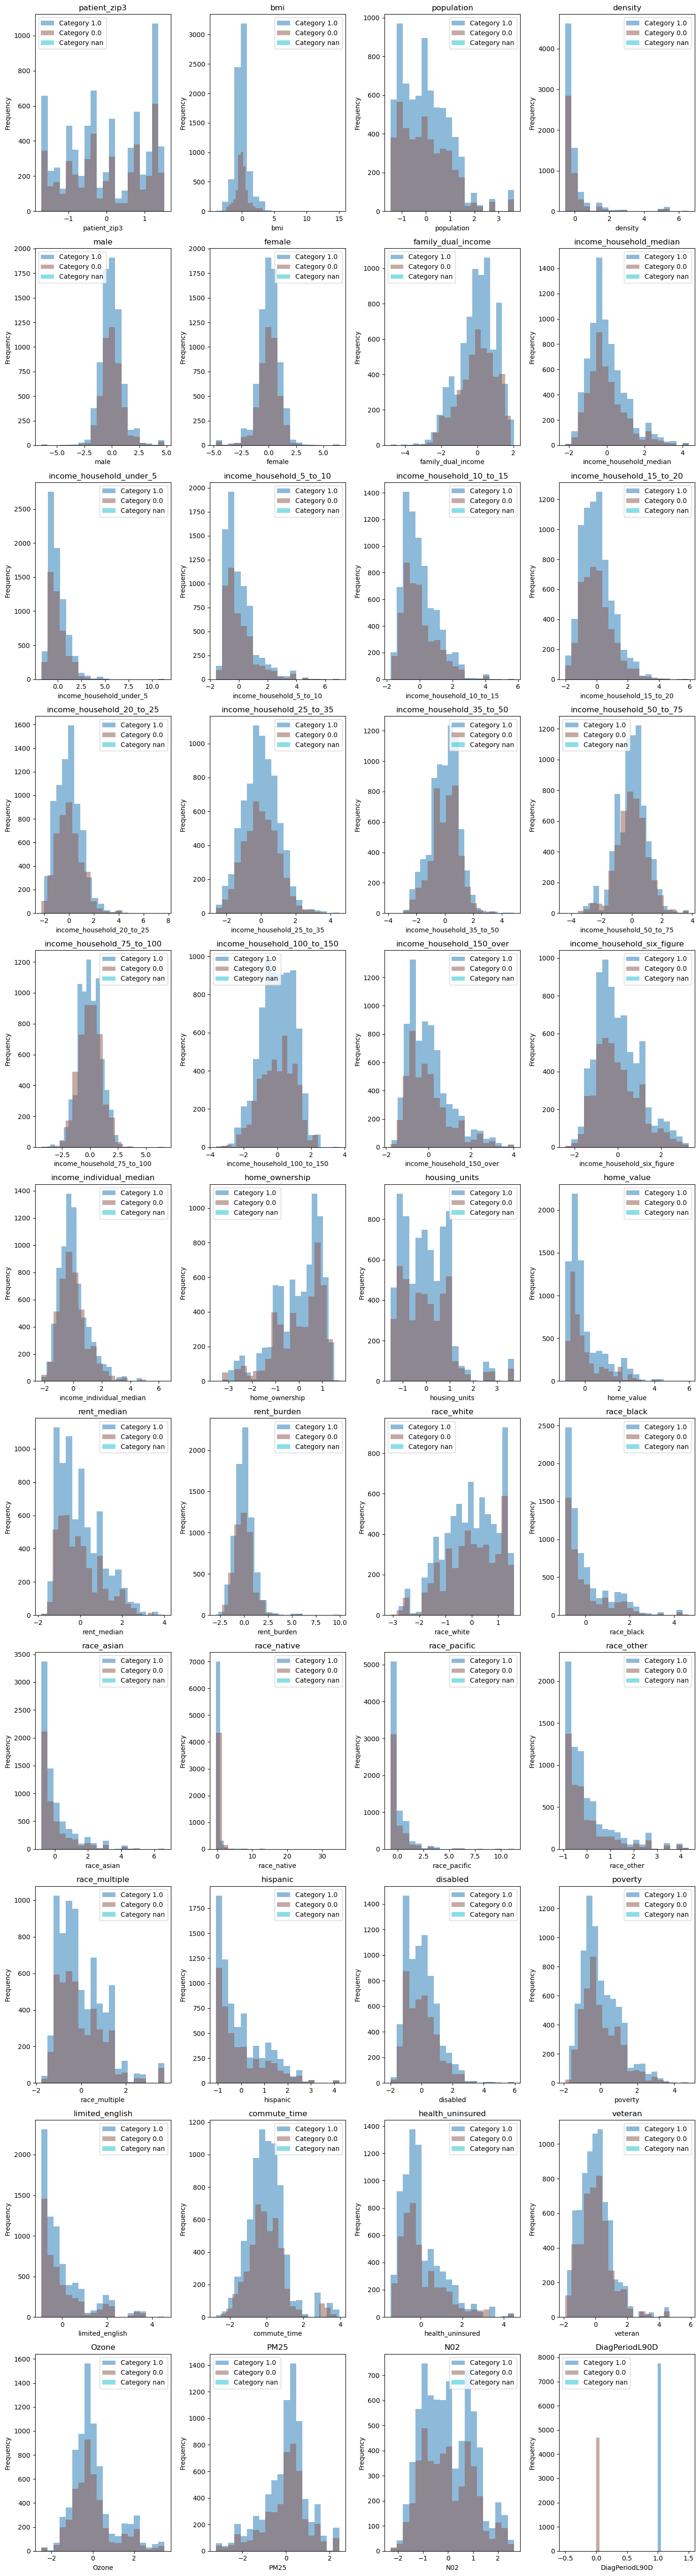

In [24]:
# Look at features
numerical_columns = processed_data.select_dtypes(include=['float64', 'int64']).columns

categorical_feature = 'DiagPeriodL90D'
categories = processed_data[categorical_feature].unique()

colors = plt.cm.get_cmap('tab10', len(categories)) 
n_columns = 4  
n_rows = int(np.ceil(len(numerical_columns) / n_columns))

plt.figure(figsize=(15, 5 * n_rows)) 

for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(n_rows, n_columns, i)  
    for j, category in enumerate(categories):
        category_data = processed_data[processed_data[categorical_feature] == category]
        plt.hist(category_data[col], bins=20, color=colors(j), alpha=0.5, label=f'Category {category}')
    
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(col)
    plt.legend()
    
plt.tight_layout()
plt.show()

# Preprocessing (Testing)

In [25]:
test_clean=test.copy()

In [26]:
test_clean.shape

(5792, 82)

In [27]:
test_clean.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
count,5792.000000,5792.000000,5792.000000,1777.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5792.000000,5791.000000,5792.000000,5.791000e+03,5791.000000,5791.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5791.000000,5791.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5791.000000,5791.000000,5792.000000,5792.000000,5792.000000,5778.000000,5778.000000,5778.000000
mean,549946.787983,570.217887,59.274862,28.900073,20266.872152,1510.471786,40.575472,11.119250,12.919191,13.218348,12.841374,12.063877,13.445992,12.669871,7.708020,4.013545,50.101101,49.898977,47.785025,12.741028,33.603883,5.869018,3.200133,51.743661,73804.632684,3.272925,2.521034,4.176442,3.957638,4.097660,8.445731,11.602190,17.001494,12.703247,15.791220,16.429361,32.220581,36305.093443,66.346768,7408.864278,3.331960e+05,1223.874116,31.285106,12.027330,27.885383,28.983067,19.060371,12.044722,31.105093,43.299536,61.515629,5.924224,13.144907,2.002827,70.082777,11.437775,5.262948,0.945075,0.148971,5.555768,6.566156,18.036444,13.483574,13.435855,4.292997,27.915686,8.636586,7.171897,39.788771,7.435363,15.936645
std,260988.833446,275.314510,13.076323,5.609491,13694.738314,2883.409750,4.029852,1.478579,1.909698,3.294389,2.358636,1.250266,1.607599,2.584994,2.172747,1.240229,1.667512,1.667478,7.449499,2.050688,8.028668,1.553876,0.225862,6.783944,20512.986299,1.447294,1.318399,1.752962,1.450724,1.325385,2.203642,2.517627,2.701921,1.803451,3.165370,8.850360,11.005963,8160.726716,14.000678,4860.167800,2.500832e+05,425.301686,4.941503,5.053325,8.017430,4.901240,6.193795,5.879815,11.597326,4.631933,5.998048,1.891790,3.407495,3.271179,17.945750,12.615989,6.569992,2.681518,0.670291,6.142503,3.552653,16.716396,3.693358,5.105505,4.673928,4.997893,4.142770,3.107104,3.486773,1.528655,5.894659
min,100266.000000,101.000000,18.000000,14.000000,829.515152,0.821739,20.600000,0.000000,6.314286,5.925000,1.500000,0.800000,0.000000,0.200000,0.000000,0.000000,39.725000,38.400000,0.900000,0.200000,18.294444,0.000000,2.550370,26.714286,32935.384620,0.750000,0.361538,1.093750,1.027778,1.100000,2.794595,1.700000,4.950000,4.733333,4.288889,1.194118,5.692593,4316.000000,15.850000,0.000000,6.062900e+04,448.400000,16.692308,0.000000,0.000000,7.200000,3.666667,3.094340,7.888889,27.147826,30.700000,1.131579,3.096774,0.000000,14.495652,0.096429,0.000000,0.000000,0.000000,0.002564,0.706250,0.194444,4.600000,3.433333,0.000000,13.722078,2.440000,1.200000,30.939316,2.636008,2.7603

In [29]:
test_clean.shape

(5792, 82)

In [30]:
# adjust the age ranges 

# defining bins and labels for age ranges
age_bins = [0, 19, 39, 59, 69, float('inf')]  # Define bins
age_labels = ['19 and Under', '20-39', '40-59', '60-69', 'Over 70']

test_clean['age_group'] = pd.cut(test_clean['patient_age'], bins=age_bins, labels=age_labels, right=True)
age_dummies = pd.get_dummies(test_clean['age_group'], prefix='age')

test_clean = pd.concat([test_clean, age_dummies], axis=1)

print(test_clean[['patient_age'] + list(age_dummies.columns)].head())

   patient_age  age_19 and Under  age_20-39  age_40-59  age_60-69  age_Over 70
0           54             False      False       True      False        False
1           52             False      False       True      False        False
2           61             False      False      False       True        False
3           64             False      False      False       True        False
4           40             False      False       True      False        False


In [31]:
test_clean['location_category'] = test_clean['breast_cancer_diagnosis_desc'].apply(categorize_location)

print(test_clean[['breast_cancer_diagnosis_desc', 'location_category']].head())

                        breast_cancer_diagnosis_desc      location_category
0  Malig neoplasm of upper-outer quadrant of left...   Upper-Outer Quadrant
1  Malignant neoplasm of unspecified site of left...       Unspecified Site
2  Malignant neoplasm of unsp site of right femal...  General Breast Cancer
3  Malignant neoplasm of unspecified site of left...       Unspecified Site
4  Malig neoplasm of upper-outer quadrant of left...   Upper-Outer Quadrant


In [32]:
# Replacing missing values in patient_race column with 'prefer not to answer'

test_clean['patient_race'] = test_clean['patient_race'].fillna('Prefer Not to Answer')

print(test_clean['patient_race'].value_counts())

patient_race
Prefer Not to Answer    2901
White                   1606
Black                    510
Hispanic                 347
Other                    273
Asian                    155
Name: count, dtype: int64


In [33]:
# BMI

# Grouping by age, race, and location to compute the mean BMI for each subgroup
## This will hopefully eliminate biases in the data (fingers crossed)

bmi_means = test_clean.groupby(['age_group', 'patient_race', 'patient_state'])['bmi'].mean().reset_index()
bmi_means.rename(columns={'bmi': 'mean_bmi'}, inplace=True)

test_clean = test_clean.merge(bmi_means, on=['age_group', 'patient_race', 'patient_state'], how='left')

test_clean['bmi'] = test_clean['bmi'].fillna(test_clean['mean_bmi'])


print(test_clean['bmi'].describe())

count    5395.000000
mean       28.846620
std         4.002655
min        14.000000
25%        27.000000
50%        28.660000
75%        30.652381
max        43.900000
Name: bmi, dtype: float64


In [34]:
# Replacing missing values in payer_type column with 'prefer not to answer'

test_clean['payer_type'] = test_clean['payer_type'].fillna('Prefer Not to Answer')

print(test_clean['payer_type'].value_counts())

payer_type
COMMERCIAL              2759
MEDICARE ADVANTAGE      1151
MEDICAID                1122
Prefer Not to Answer     760
Name: count, dtype: int64


In [35]:
# One-hot encode the 'location_category' column
test_clean = pd.get_dummies(test_clean, columns=['location_category'], drop_first=True)

# One-hot encode the 'patient_state' column
test_clean = pd.get_dummies(test_clean, columns=['patient_state'], drop_first=True)

In [36]:
# initial removal of columns I deem unnecesarry

test_clean=test_clean.drop(["patient_id","education_less_highschool", "education_highschool","education_some_college","education_bachelors",
                              "education_graduate","education_college_or_above","education_stem_degree","married","divorced",
                              "never_married","widowed", "age_median",'breast_cancer_diagnosis_desc','age_under_10','age_10_to_19','age_20s','age_30s',
                         'age_30s','age_40s','age_50s','age_60s','age_70s','age_over_80','patient_age','patient_race',
                         'patient_gender','breast_cancer_diagnosis_code','breast_cancer_diagnosis_code',
                          'metastatic_cancer_diagnosis_code','metastatic_first_novel_treatment','metastatic_first_novel_treatment_type',
                         'Region','Division','labor_force_participation','unemployment_rate','self_employed','farmer','family_size','payer_type'], axis=1)



In [37]:
# drop rows from all columns that now have less than 500 missing values
columns_to_drop_missing = test_clean.columns[test_clean.isnull().sum() < 500]

test_clean = test_clean.dropna(subset=columns_to_drop_missing)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(test_clean.isnull().sum())

patient_zip3                                      0
bmi                                               0
population                                        0
density                                           0
male                                              0
female                                            0
family_dual_income                                0
income_household_median                           0
income_household_under_5                          0
income_household_5_to_10                          0
income_household_10_to_15                         0
income_household_15_to_20                         0
income_household_20_to_25                         0
income_household_25_to_35                         0
income_household_35_to_50                         0
income_household_50_to_75                         0
income_household_75_to_100                        0
income_household_100_to_150                       0
income_household_150_over                         0
income_house

In [40]:
# Save the clean test dataset as a CSV file

test_clean.to_csv('test_preprocessed.csv', index=False)

The new csv files to be used for machine learning will be called:
'processed_train_clean.csv' and 'test_preprocessed.csv'
